<h2>Model Training</h2>

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_data_dir = r"imagenette2-160\train"
val_data_dir = r"imagenette2-160\val"
test_data_dir = r"imagenette2-160\test"

img_height = 150
img_width = 150

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 4750 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen.flow_from_directory(
    r"imagenette2-160\train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4750 images belonging to 5 classes.


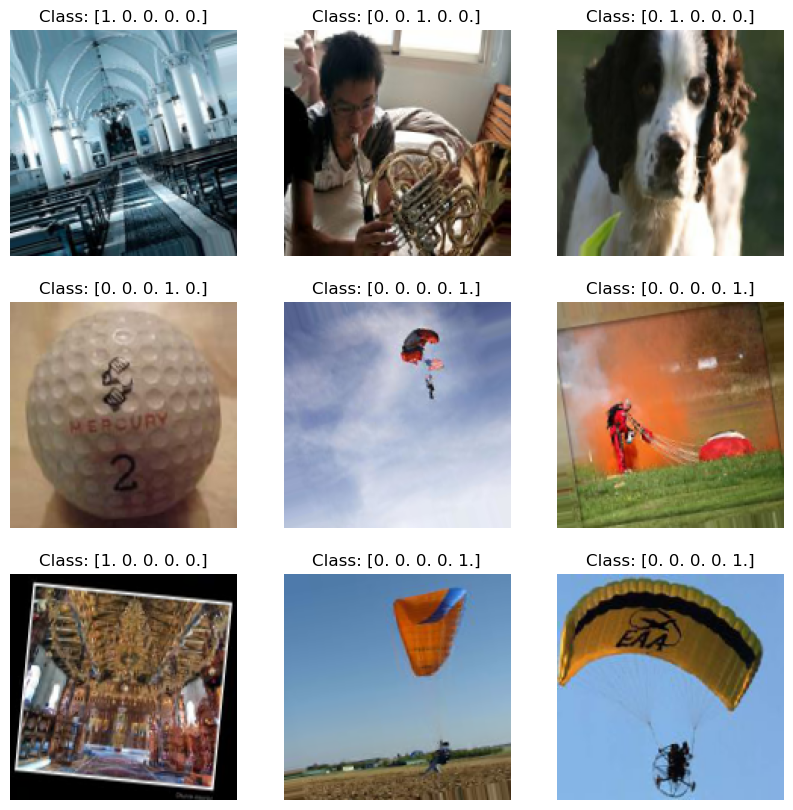

In [7]:
import matplotlib.pyplot as plt

batch = next(train_generator_augmented)
images, labels = batch

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title('Class: {}'.format(labels[i]))
    plt.axis('off')
plt.show()

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

output_tensor = base_model.output
x = Flatten()(output_tensor)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 114s 2us/step


In [13]:
epochs = 3
steps_per_epoch = train_generator.n // train_generator_augmented.batch_size
validation_steps = val_generator.n // val_generator.batch_size

In [15]:
history = model.fit(
    train_generator_augmented,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/3
148/148 [==============================] - 314s 2s/step - loss: 0.4660 - accuracy: 0.8368 - val_loss: 0.2412 - val_accuracy: 0.9153
Epoch 2/3
148/148 [==============================] - 362s 2s/step - loss: 0.2366 - accuracy: 0.9163 - val_loss: 0.1998 - val_accuracy: 0.9335
Epoch 3/3
148/148 [==============================] - 305s 2s/step - loss: 0.1790 - accuracy: 0.9364 - val_loss: 0.2413 - val_accuracy: 0.9214


In [17]:
model.save('trained_model.keras')

In [19]:
from tensorflow.keras.models import load_model

In [21]:
loaded_model = load_model('trained_model.keras')

<h2>Model Evaluation</h2>

In [23]:
evaluation = loaded_model.evaluate(train_generator)
print("Train Loss:", evaluation[0])
print("Train Accuracy:", evaluation[1])

149/149 [==============================] - 240s 2s/step - loss: 0.1417 - accuracy: 0.9497
Train Loss: 0.14165817201137543
Train Accuracy: 0.949684202671051


In [24]:
evaluation = loaded_model.evaluate(val_generator)
print("Val Loss:", evaluation[0])
print("Val Accuracy:", evaluation[1])

32/32 [==============================] - 54s 2s/step - loss: 0.2395 - accuracy: 0.9220
Val Loss: 0.23949623107910156
Val Accuracy: 0.921999990940094


In [25]:
evaluation = loaded_model.evaluate(test_generator)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

32/32 [==============================] - 56s 2s/step - loss: 0.2729 - accuracy: 0.9100
Test Loss: 0.2729189395904541
Test Accuracy: 0.9100000262260437


<h2>Grad-CAM</h2>

In [127]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
import numpy as np
from matplotlib import cm

In [129]:
gradcam = Gradcam(loaded_model)

In [131]:
image_titles = ["church", "dog", "french horn", "golf ball", "parachute"]

In [135]:
image_class_samples = next(test_generator)
image_samples = image_class_samples[0]
class_samples = image_class_samples[1]

In [137]:
all_classes_examples = []
for class_searched in range(5):
    for image_sample, class_sample in zip(image_samples, class_samples):
        if np.where(class_sample == 1)[0][0] == class_searched:
            all_classes_examples.append(image_sample)
            break

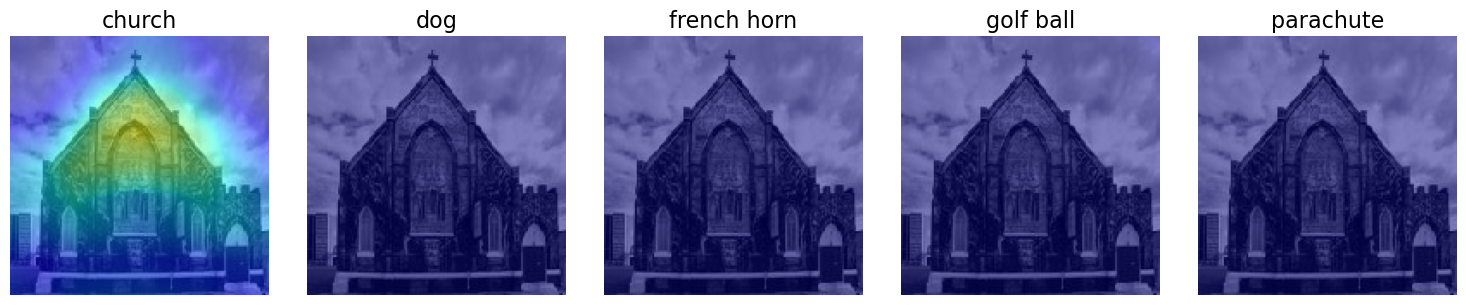

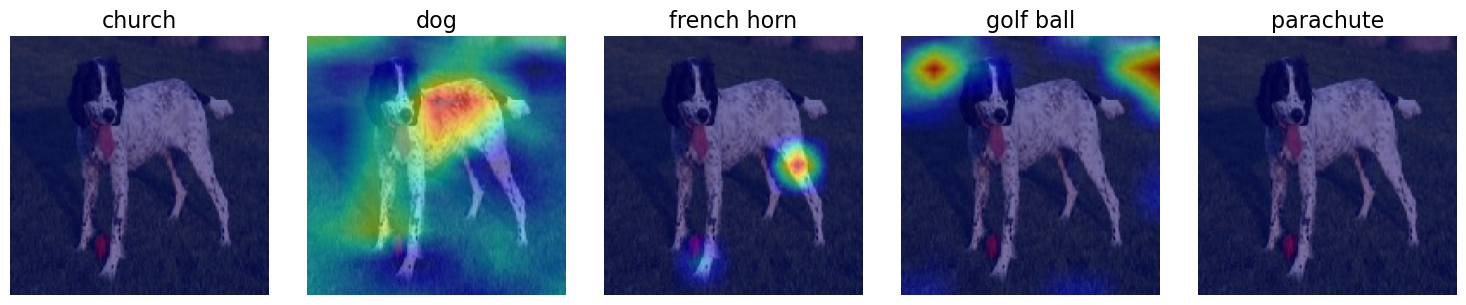

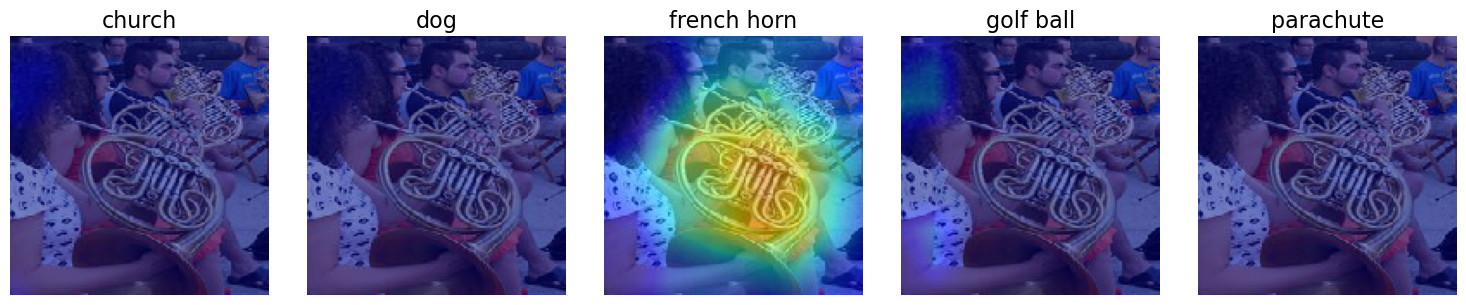

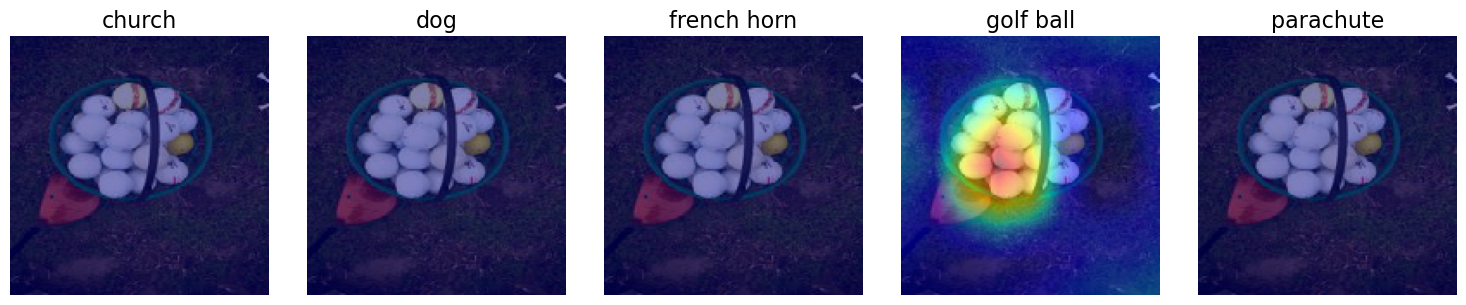

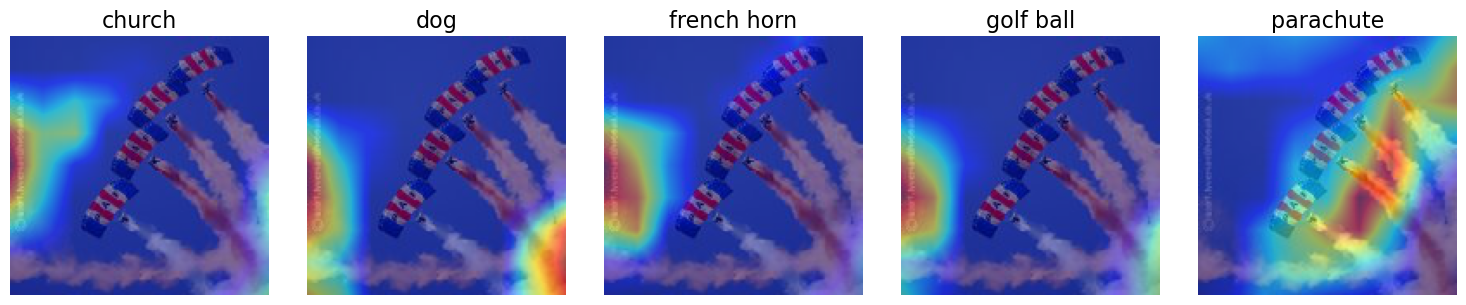

In [139]:
for image_sample in all_classes_examples:
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
    for i, title in enumerate(image_titles):
        score = CategoricalScore(i)
        cam = gradcam(score,
                  image_sample,
                  penultimate_layer=-1)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(image_sample, cmap='gray')
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()